# Lab 4: Text-to-Speech (TTS)

## <span style="color:darkblue"> Introduction </span>


In this lab, first, we will study how to build and evaluate a neural-based TTS system using a pretrained Tacotron 2 in torchaudio and different vocoders. Then, we will use a multi-speaker TTS model for experiments with different voices using SpeechBrain pretrained models.


The TTS pipeline comprises 3 steps:

<img src="tts.png">


#### <span style="color:green"> Step 1. Text processing </span>

The input text is encoded into a list of symbols. We will use English characters and phonemes as the symbols. A phonemizer transforms text into phoneme sequences. Phonemes are textual representations of the pronunciation of words.

#### <span style="color:green"> Step 2. Spectrogram generation </span>

From the encoded text, a spectrogram is generated. We use the ``Tacotron 2``
model for this.

#### <span style="color:green"> Step 3. Conversion of the spectrogram into a waveform (speech generation) </span>

The spectrogram is converted into a speech waveform using a Vocoder.
In this lab, three different vocoders are used,
   :py:class:`~torchaudio.models.WaveRNN`,
   :py:class:`~torchaudio.transforms.GriffinLim`, and
   [Nvidia's WaveGlow](https://pytorch.org/hub/nvidia_deeplearningexamples_tacotron2/).


The related components are bundled in :py:class:`torchaudio.pipelines.Tacotron2TTSBundle`.

<hr/>

#### Block diagram of the Tacotron 2 system architecture

<img src="https://pytorch.org/assets/images/tacotron2_diagram.png" width="500">

The Tacotron 2 and WaveGlow model form a TTS system that enables user to synthesise a natural sounding speech from raw transcripts without any additional prosody information.
The Tacotron 2 model produces mel spectrograms from input text using encoder-decoder architecture.
WaveGlow is a flow-based model that consumes the mel spectrograms to generate speech.

*Note:
    This lab is partly based on the [torchaudio tutorial](https://pytorch.org/audio/stable/tutorials/tacotron2_pipeline_tutorial.html) and [SpeechBrain](https://github.com/speechbrain/speechbrain) examples.*

In [1]:
import os
import torch
import torchaudio
import IPython
import matplotlib.pyplot as plt

torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchaudio.__version__)
print(device)

2.5.1+cu121
2.5.1+cu121
cuda


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Speech and transcripts sub-directories paths
data_dir = "./asr-dataset"
# data_dir = "/content/drive/MyDrive/asr-dataset"
data_speech_dir = os.path.join(data_dir, 'speech')
data_transc_dir = os.path.join(data_dir, 'transcription')

## <span style="color:green"> Step 1. Text processing </span>

### Character-based encoding

In this section, we will learn how character-based encoding works.

Since the pre-trained Tacotron 2 model expects specific set of symbol
tables, the same functionalities is available in ``torchaudio``. However,
we will first manually implement the encoding for better understanding.

First, we define a set of symbols
``'_-!\'(),.:;? abcdefghijklmnopqrstuvwxyz'``. Then, we map  each character of the input text into the index of the corresponding symbol in the table. Symbols that are not in the table are ignored.



In [4]:
symbols = "_-!'(),.:;? abcdefghijklmnopqrstuvwxyz"
look_up = {s: i for i, s in enumerate(symbols)}
symbols = set(symbols)

def text_to_sequence(text):
    text = text.lower()
    return [look_up[s] for s in text if s in symbols]

text = "We are studing text-to-speech models with different vocoders. What are the differences between these models?"
print(text_to_sequence(text))

[34, 16, 11, 12, 29, 16, 11, 30, 31, 32, 15, 20, 25, 18, 11, 31, 16, 35, 31, 1, 31, 26, 1, 30, 27, 16, 16, 14, 19, 11, 24, 26, 15, 16, 23, 30, 11, 34, 20, 31, 19, 11, 15, 20, 17, 17, 16, 29, 16, 25, 31, 11, 33, 26, 14, 26, 15, 16, 29, 30, 7, 11, 34, 19, 12, 31, 11, 12, 29, 16, 11, 31, 19, 16, 11, 15, 20, 17, 17, 16, 29, 16, 25, 14, 16, 30, 11, 13, 16, 31, 34, 16, 16, 25, 11, 31, 19, 16, 30, 16, 11, 24, 26, 15, 16, 23, 30, 10]


As mentioned above, the symbol table and indices must match
what the pretrained Tacotron 2 model expects. ``torchaudio`` provides the same
transform along with the pretrained model. You can
instantiate and use such transform as follows.

In [5]:
processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()

text = "We are studing text-to-speech models with different vocoders. What are the differences between these models?"
processed, lengths = processor(text)

print(processed)
print(lengths)

tensor([[34, 16, 11, 12, 29, 16, 11, 30, 31, 32, 15, 20, 25, 18, 11, 31, 16, 35,
         31,  1, 31, 26,  1, 30, 27, 16, 16, 14, 19, 11, 24, 26, 15, 16, 23, 30,
         11, 34, 20, 31, 19, 11, 15, 20, 17, 17, 16, 29, 16, 25, 31, 11, 33, 26,
         14, 26, 15, 16, 29, 30,  7, 11, 34, 19, 12, 31, 11, 12, 29, 16, 11, 31,
         19, 16, 11, 15, 20, 17, 17, 16, 29, 16, 25, 14, 16, 30, 11, 13, 16, 31,
         34, 16, 16, 25, 11, 31, 19, 16, 30, 16, 11, 24, 26, 15, 16, 23, 30, 10]])
tensor([108], dtype=torch.int32)


Note: The output of our manual encoding and the ``torchaudio`` ``text_processor`` output matches (meaning we correctly re-implemented what the library does internally). It takes either a text or list of texts as inputs.
When a list of texts are provided, the returned ``lengths`` variable
represents the valid length of each processed tokens in the output
batch.

The intermediate representation can be retrieved as follows:




In [6]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['w', 'e', ' ', 'a', 'r', 'e', ' ', 's', 't', 'u', 'd', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', '-', 't', 'o', '-', 's', 'p', 'e', 'e', 'c', 'h', ' ', 'm', 'o', 'd', 'e', 'l', 's', ' ', 'w', 'i', 't', 'h', ' ', 'd', 'i', 'f', 'f', 'e', 'r', 'e', 'n', 't', ' ', 'v', 'o', 'c', 'o', 'd', 'e', 'r', 's', '.', ' ', 'w', 'h', 'a', 't', ' ', 'a', 'r', 'e', ' ', 't', 'h', 'e', ' ', 'd', 'i', 'f', 'f', 'e', 'r', 'e', 'n', 'c', 'e', 's', ' ', 'b', 'e', 't', 'w', 'e', 'e', 'n', ' ', 't', 'h', 'e', 's', 'e', ' ', 'm', 'o', 'd', 'e', 'l', 's', '?']


### Phoneme-based encoding

Phoneme-based encoding is similar to character-based encoding, but it
uses a symbol table based on phonemes and a G2P (Grapheme-to-Phoneme)
model.

The detail of the G2P model is out of the scope of this tutorial, we will
just look at what the conversion looks like.

Similar to the case of character-based encoding, the encoding process is
expected to match what a pretrained Tacotron 2 model is trained on.
``torchaudio`` has an interface to create the process.

The following code illustrates how to make and use the process. Behind
the scene, a G2P model is created using ``DeepPhonemizer`` package, and
the pretrained weights published by the author of ``DeepPhonemizer`` is
fetched.




In [4]:
!pip install deep_phonemizer

  Preparing metadata (setup.py) ... done
  Created wheel for deep_phonemizer: filename=deep_phonemizer-0.0.19-py3-none-any.whl size=33273 sha256=11e7518e5e65b20550d19bbc48b868835877b4f24c536622ab2605643aa22a95
  Stored in directory: /root/.cache/pip/wheels/c7/61/da/39b050eea5710fe32b1521b79de4a74d95896581230d30a37b
Successfully built deep_phonemizer


In [9]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()

text = "We are studing text-to-speech models with different vocoders. What are the differences between these models?"
with torch.inference_mode():
    processed, lengths = processor(text)

print(processed)
print(lengths)

100%|██████████| 63.6M/63.6M [00:04<00:00, 16.7MB/s]
/usr/local/lib/python3.10/dist-packages/dp/model/model.py:306: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint 

tensor([[92, 59, 11, 12, 78, 11, 79, 81, 87, 38, 55, 68, 11, 81, 40, 64, 79, 81,
          1, 81, 20,  1, 79, 77, 59, 37, 11, 66, 12, 38, 20, 65, 94, 11, 92, 55,
         39, 11, 38, 55, 52, 44, 20, 67, 81, 11, 91, 69, 64, 69, 38, 44, 94,  7,
         11, 54, 92, 20, 81, 11, 12, 78, 11, 39, 20, 11, 38, 55, 52, 44, 20, 67,
         79, 55, 94, 11, 36, 55, 81, 92, 59, 67, 11, 39, 59, 94, 11, 66, 12, 38,
         20, 65, 94, 10]])
tensor([94], dtype=torch.int32)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Notice that the encoded values are different from the example of
character-based encoding.

The intermediate representation looks as follows.


In [10]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['W', 'IY', ' ', 'AA', 'R', ' ', 'S', 'T', 'UW', 'D', 'IH', 'NG', ' ', 'T', 'EH', 'K', 'S', 'T', '-', 'T', 'AH', '-', 'S', 'P', 'IY', 'CH', ' ', 'M', 'AA', 'D', 'AH', 'L', 'Z', ' ', 'W', 'IH', 'DH', ' ', 'D', 'IH', 'F', 'ER', 'AH', 'N', 'T', ' ', 'V', 'OW', 'K', 'OW', 'D', 'ER', 'Z', '.', ' ', 'HH', 'W', 'AH', 'T', ' ', 'AA', 'R', ' ', 'DH', 'AH', ' ', 'D', 'IH', 'F', 'ER', 'AH', 'N', 'S', 'IH', 'Z', ' ', 'B', 'IH', 'T', 'W', 'IY', 'N', ' ', 'DH', 'IY', 'Z', ' ', 'M', 'AA', 'D', 'AH', 'L', 'Z', '?']


## <span style="color:green"> Step 2. Spectrogram generation </span>


``Tacotron 2`` is the model we use to generate spectrogram from the
encoded text. For more details, please refer to [the
paper](https://arxiv.org/abs/1712.05884).

It is easy to instantiate a Tacotron 2 model with pretrained weights,
however, note that the input to Tacotron 2 models need to be processed
by the matching text processor.

:py:class:`torchaudio.pipelines.Tacotron2TTSBundle` bundles the matching
models and processors together so that it is easy to create the pipeline.

For the available bundles, and its usage, please refer to
:py:class:`~torchaudio.pipelines.Tacotron2TTSBundle`.




Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_phonemes_1500_epochs_wavernn_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/tacotron2_english_phonemes_1500_epochs_wavernn_ljspeech.pth
100%|██████████| 107M/107M [00:01<00:00, 69.1MB/s]


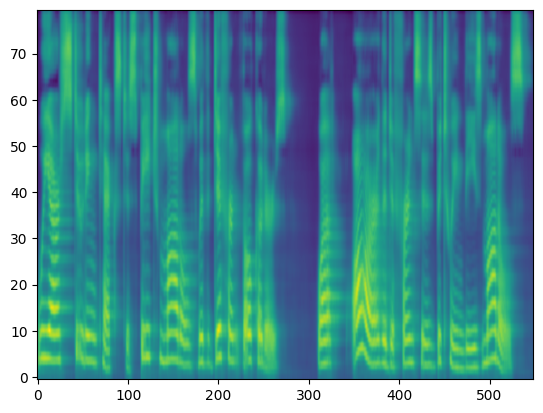

In [11]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)

text = "We are studing text-to-speech models with different vocoders. What are the differences between these models?"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, _, _ = tacotron2.infer(processed, lengths)

_ = plt.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")

Note that ``Tacotron2.infer`` method perfoms multinomial sampling,
therefore, the process of generating the spectrogram incurs randomness.




torch.Size([80, 588])
torch.Size([80, 598])
torch.Size([80, 540])


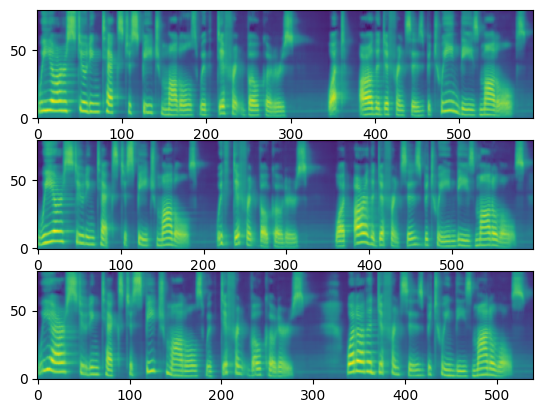

In [12]:
def plot():
    fig, ax = plt.subplots(3, 1)
    for i in range(3):
        with torch.inference_mode():
            spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
        print(spec[0].shape)
        ax[i].imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")

plot()

## <span style="color:green"> Step 3. Waveform generation using different vocoders </span>

The obtained pectrogram is used to generate a waveform using a vocoder.

``torchaudio`` provides vocoders based on ``GriffinLim`` and ``WaveRNN``.




### WaveRNN vocoder

Continuing from the previous section, we can instantiate the matching
WaveRNN model from the same bundle.




In [13]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

text = "We are studing text-to-speech models with different vocoders. What are the differences between these models?"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    waveforms, lengths = vocoder(spec, spec_lengths)

Downloading: "https://download.pytorch.org/torchaudio/models/wavernn_10k_epochs_8bits_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/wavernn_10k_epochs_8bits_ljspeech.pth
100%|██████████| 16.7M/16.7M [00:00<00:00, 33.2MB/s]


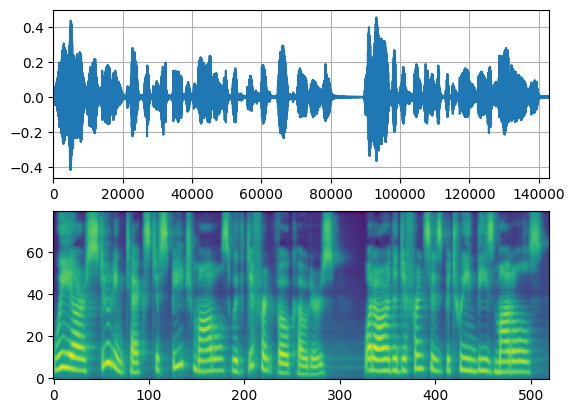

In [14]:
def plot(waveforms, spec, sample_rate):
    waveforms = waveforms.cpu().detach()

    fig, [ax1, ax2] = plt.subplots(2, 1)
    ax1.plot(waveforms[0])
    ax1.set_xlim(0, waveforms.size(-1))
    ax1.grid(True)
    ax2.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
    return IPython.display.Audio(waveforms[0:1], rate=sample_rate)

plot(waveforms, spec, vocoder.sample_rate)

### Griffin-Lim vocoder

The usage of the Griffin-Lim vocoder is similar to WaveRNN. You can instantiate the vocoder object with
:py:func:`~torchaudio.pipelines.Tacotron2TTSBundle.get_vocoder`
method and pass the spectrogram.




In [15]:
bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    waveforms, lengths = vocoder(spec, spec_lengths)

Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_phonemes_1500_epochs_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/tacotron2_english_phonemes_1500_epochs_ljspeech.pth
100%|██████████| 107M/107M [00:00<00:00, 123MB/s] 


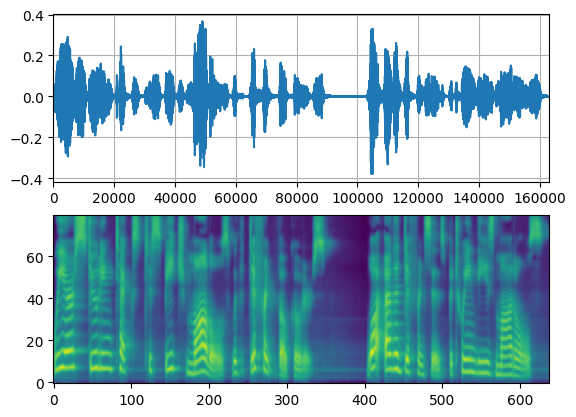

In [16]:
plot(waveforms, spec, vocoder.sample_rate)

### Waveglow vocoder

Waveglow is a vocoder published by Nvidia. The pretrained weights are
published on Torch Hub. One can instantiate the model using ``torch.hub``
module.

In [17]:
# Workaround to load model mapped on GPU
# https://stackoverflow.com/a/61840832
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)
checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",  # noqa: E501
    progress=False,
    map_location=device,
)
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}

waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():
    waveforms = waveglow.infer(spec)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn

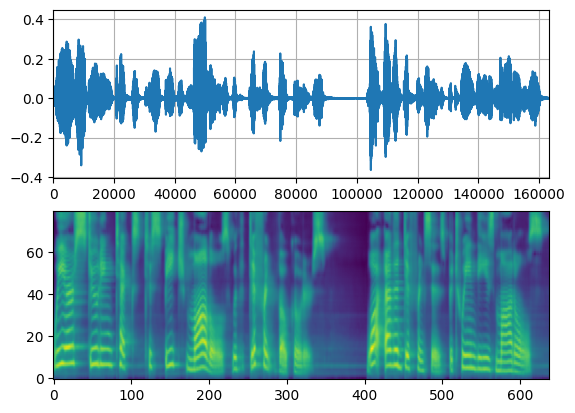

In [18]:
plot(waveforms, spec, 22050)

<span style="color:red"> **Exercise 1**</span>

<span style="color:orange"> **Speech-to-text generation and subjective evaluation**</span>


1. Take a fragment of an arbitrary text (a few utterances).
2. Synthesize this text using the Tacotron-2 model and 3 different vocoders (Griffin-Lim, WaveRNN, and Waveglow).
3. Listen to the obtained synthesised audio samples and evaluate them in terms of speech naturalness and intelligibility using the scale 1..5. See slides #6-8 *Subjective Evaluation* for more details on the criteria of evaluation.
4. Based on these scores, perform ranking of the vocoders and describe the problems you observe (mispronunciation, wrong intonation, etc.) for each vocoder regarding speech naturalness and intelligibility and provide audio examples (one for each factor is sufficient).




In [7]:
text = "Large language models are revolutionizing the way we interact with technology."

# encode the text into spectogram by Tacotron-2
# Load Tacotron-2 bundle
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)

with torch.inference_mode():
    processed, lengths = processor(text)
    processed, lengths = processed.to(device), lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)

In [20]:
# Synthesize speech - Griffin-Lim

bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH
vocoder = bundle.get_vocoder().to(device)
with torch.inference_mode():
    waveforms, _ = vocoder(spec, spec_lengths)
torchaudio.save("griffin_lim.wav", waveforms.cpu(), sample_rate=vocoder.sample_rate)

In [21]:
# Synthesize speech - WaveRNN
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
vocoder = bundle.get_vocoder().to(device)
with torch.inference_mode():
    waveforms, _ = vocoder(spec, spec_lengths)
torchaudio.save("wave_rnn.wav", waveforms.cpu(), sample_rate=vocoder.sample_rate)

In [22]:
# Synthesize speech - WaveGlow
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)
# Load checkpoint
checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",
    map_location=device,
)
waveglow.load_state_dict({key.replace("module.", ""): val for key, val in checkpoint["state_dict"].items()})
waveglow = waveglow.remove_weightnorm(waveglow).to(device)
with torch.no_grad():
    waveforms = waveglow.infer(spec)
torchaudio.save("wave_glow.wav", waveforms.cpu(), sample_rate=22050)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [23]:
from IPython.display import Audio

Audio("griffin_lim.wav")

In [24]:
Audio("wave_rnn.wav")

In [25]:
Audio("wave_glow.wav")

**Griffin-Lim**

Naturalness: 1

Intelligibility: 3

Average: 2.0

**WaveRNN**

Naturalness: 4

Intelligibility: 3

Average: 3.5


**WaveGlow**:

Naturalness: 2

Intelligibility: 3

Average: 2.5

**Ranking of Vocoder:**

1	WaveRNN	: The speech sounds very close to human, with smooth transitions and relatively natural prosody. One word still sound clipped "interact".

2	WaveGlow : Speech sounds slightly more natural than Griffin-Lim but still exhibits issues with prosody and intonation. Background noise and subtle hissing may degrade the quality.  Certain words might have unnatural emphasis.

3	Griffin-Lim : The speech sounds highly robotic and unnatural. Certain words sound clipped - "interact", making it less clear in challenging sentences.



## <span style="color:green"> Objective evaluation </span>

### Objective evaluation using ASR

Sometimes, instead of human listeners, the ASR model can be used as an analogue for speech intelligibility assessment.

The WER metric is computed between the reference text and the output of the ASR system applied to the synthesized speech sample.



### Objective evaluation using NISQA (Non Intrusive Speech Quality Assessment)

This part is devoted to objective evaluation of speech quality/nauralness using NISQA models.
In the current examples, for simplicity, a general NISQA model for speech quality evaluation is used. For evaluaton of TTS results, in practice, a specified NISQA-TTS model should be used.
In the output, the first value corresponds to the overal MOS quality estimation that is suggested to use in this lab.

In [26]:
# workaround - link to notebook with it : https://colab.research.google.com/drive/1oykyta9z06BaHwhjYfp2k3SX3emxbcgR?usp=sharing#scrollTo=LZU5OlW97eSG
import locale

locale.getpreferredencoding = lambda: "UTF-8"

!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 22.5 MB/s eta 0:00:00


downloading https://github.com/gabrielmittag/NISQA/raw/refs/heads/master/weights/nisqa.tar to /root/.torchmetrics/NISQA/nisqa.tar
INFO:torchmetrics:downloading https://github.com/gabrielmittag/NISQA/raw/refs/heads/master/weights/nisqa.tar to /root/.torchmetrics/NISQA/nisqa.tar


tensor([3.1704, 3.2544, 3.8850, 3.4388, 3.8179])


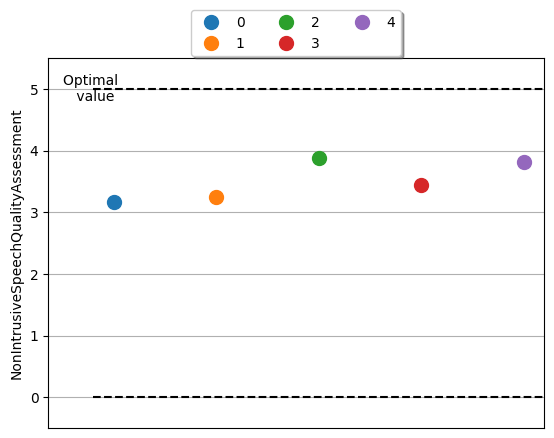

In [27]:
from torchmetrics.audio import NonIntrusiveSpeechQualityAssessment
nisqa = NonIntrusiveSpeechQualityAssessment(22050)

waveform, sr = torchaudio.load('wave_glow.wav', channels_first=True)
nisqa.update(waveform)
fig, ax_ = nisqa.plot()
fig.savefig("nisqa_synthesized_test.png")

# Float tensor with shape (...,5)
# corresponding to overall MOS, noisiness, discontinuity, coloration and loudness in that order
print(nisqa(waveform))

### Objective evaluation using wv-MOS

This part is devoted to objective MOS score prediction by the fine-tuned wav2vec2.0 model.

In [30]:
from wvmos import get_wvmos

Weights downloaded in: /root/.cache/wv_mos/wv_mos.ckpt Size: 378728387


In [31]:
model = get_wvmos(cuda=False)

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:306: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/wvmos/wv_mos.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(extract_prefix('model.', torch.load(path)['sta

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:306: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

In [32]:
mos = model.calculate_one(os.path.join(data_speech_dir, "237-126133-0009.wav")) # infer MOS score for one audio
print(mos)
#mos = model.calculate_dir("path/to/dir/with/wav/files", mean=True) # infer average MOS score across .wav files in directory

4.57973051071167


<span style="color:red"> **Exercise 2**</span>

<span style="color:orange"> **Objective evaluation** </span>

1. Use text transcripts from the text files in */asr-dataset/transcription* (directory from the previous ASR labs). Select a subsample of 20 files, preferably including all different speakers of the original dataset (different speakers have different first numbers in the file names, i.e. file 121-121726-0002.txt corresponds to speaker #121, file 61-70968-0018.txt - to speaker #61). Synthesize speech for these files three times using three different vocoders.
2. Compute MOS naturalness and MOS quality predictions using neural network wv-MOS and NISQA models and compare them.
3. Do you observe similar or different ranking of the TTS systems when using subjective (in Exercise 1) and objective scores?



In [5]:
from tqdm import tqdm

output_dir = os.path.join(data_dir, "output")

# Select a diverse subset of 20 files
transc_files = os.listdir(data_transc_dir)
speakers = {}
selected_files = []

for file in transc_files:
    speaker_id = file.split("-")[0]
    if speaker_id not in speakers:
        speakers[speaker_id] = []
    speakers[speaker_id].append(file)

# Limit to a maximum of 7 files per speaker and total 20 files
for speaker_id, files in speakers.items():
    selected_files.extend(files[:7])  # Up to 7 files per speaker
    if len(selected_files) >= 20:
        break

selected_files = selected_files[:20]  # Ensure exactly 20 files
print("Selected Files:", selected_files)

# Ensure output directories exist for each vocoder
vocoder_dirs = ["griffin_lim", "wave_rnn", "wave_glow"]
for vocoder in vocoder_dirs:
    vocoder_dir = os.path.join(output_dir, vocoder)
    os.makedirs(vocoder_dir, exist_ok=True)

Selected Files: ['121-127105-0017.txt', '121-127105-0014.txt', '121-127105-0016.txt', '121-127105-0015.txt', '121-127105-0006.txt', '121-127105-0010.txt', '121-127105-0012.txt', '61-70970-0032.txt', '61-70970-0018.txt', '61-70970-0030.txt', '61-70968-0003.txt', '61-70970-0019.txt', '61-70968-0016.txt', '61-70968-0029.txt', '237-126133-0004.txt', '237-126133-0012.txt', '237-126133-0008.txt', '237-126133-0025.txt', '237-126133-0021.txt', '237-126133-0018.txt']


In [34]:
# Load Tacotron-2 and vocoders
wave_rnn_bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
griffin_lim_bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH
processor = wave_rnn_bundle.get_text_processor()
tacotron2 = wave_rnn_bundle.get_tacotron2().to(device)
vocoder_rnn = wave_rnn_bundle.get_vocoder().to(device)
vocoder_griffin = griffin_lim_bundle.get_vocoder().to(device)

# Load WaveGlow
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub", "nvidia_waveglow", model_math="fp32", pretrained=False
)
checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",
    map_location=device,
)
waveglow.load_state_dict({key.replace("module.", ""): val for key, val in checkpoint["state_dict"].items()})
waveglow = waveglow.remove_weightnorm(waveglow).to(device).eval()

/usr/local/lib/python3.10/dist-packages/dp/model/model.py:306: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
/u

In [35]:
# Synthesize speech
def synthesize_speech(input_text, output_path, vocoder_name):
    processed, lengths = processor(input_text)
    processed, lengths = processed.to(device), lengths.to(device)
    spec, _, _ = tacotron2.infer(processed, lengths)

    if vocoder_name == "wave_glow":
        with torch.no_grad():
            waveforms = waveglow.infer(spec)
    else:
        vocoder = vocoder_griffin if vocoder_name == "griffin_lim" else vocoder_rnn
        with torch.inference_mode():
            waveforms, _ = vocoder(spec, lengths)

    torchaudio.save(output_path, waveforms.cpu(), sample_rate=22050)


# Process files for each vocoder
def process_vocoder(vocoder_name):
    vocoder_output_dir = os.path.join(output_dir, vocoder_name)
    for file in tqdm(selected_files, desc=f"{vocoder_name} Progress"):
        text_file = os.path.join(data_transc_dir, file)
        output_file = os.path.join(vocoder_output_dir, file.replace(".txt", ".wav"))

        with open(text_file, "r") as f:
            text = f.read()

        synthesize_speech(text, output_file, vocoder_name)


In [40]:
# Process and evaluate speech
for vocoder in vocoder_dirs:
    process_vocoder(vocoder)

wave_glow Progress: 100%|██████████| 20/20 [00:43<00:00,  2.19s/it]


In [48]:
from torchmetrics.audio import NonIntrusiveSpeechQualityAssessment
from wvmos import get_wvmos

# Evaluate speech
def evaluate_vocoder(vocoder_name):
    vocoder_output_dir = os.path.join(output_dir, vocoder_name)

    # Initialize evaluation models
    mos_model = get_wvmos(cuda=torch.cuda.is_available())
    nisqa = NonIntrusiveSpeechQualityAssessment(22050)

    nisqa_scores = []
    for file in tqdm(os.listdir(vocoder_output_dir), desc=f"Evaluating {vocoder_name}"):
        audio_path = os.path.join(vocoder_output_dir, file)
        waveform, _ = torchaudio.load(audio_path)

        # Update NISQA and get overall MOS score
        nisqa.update(waveform)
        overall_mos = nisqa(waveform)[0].item()  # Extract only the overall MOS score
        nisqa_scores.append(overall_mos)

    # Calculate average MOS score using wv-MOS
    mos_scores = mos_model.calculate_dir(vocoder_output_dir, mean=True)

    return nisqa_scores, mos_scores

# Compute and display results for all vocoders
results = {}
for vocoder_name in vocoder_dirs:
    nisqa_scores, mos_scores = evaluate_vocoder(vocoder_name)
    results[vocoder_name] = {
        "NISQA": nisqa_scores,
        "wv-MOS": mos_scores
    }
    print(f"Results for {vocoder_name}:")
    print(f"  NISQA Scores (Overall MOS): {nisqa_scores}")
    print(f"  wv-MOS Score: {mos_scores}")
    print("-" * 50)

100%|██████████| 20/20 [00:00<00:00, 30.25it/s]
/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:306: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Results for griffin_lim:
  NISQA Scores (Overall MOS): [3.7511801719665527, 4.008922100067139, 4.162257671356201, 2.6485135555267334, 3.8432695865631104, 3.046252965927124, 3.3016138076782227, 2.921125888824463, 3.2795286178588867, 2.8962581157684326, 3.5381019115448, 3.401020050048828, 3.7930312156677246, 4.249204158782959, 3.3150906562805176, 2.8957526683807373, 3.5470452308654785, 2.786468744277954, 3.6200191974639893, 4.0006632804870605]
  wv-MOS Score: 3.015144395828247
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/wvmos/wv_mos.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(extract_prefix('model.', torch.load(path)['sta

Results for wave_rnn:
  NISQA Scores (Overall MOS): [3.733322858810425, 3.3141753673553467, 3.7120521068573, 3.444769859313965, 3.994311571121216, 3.3244590759277344, 3.5922396183013916, 4.0488810539245605, 3.42815899848938, 3.08548641204834, 3.895388603210449, 3.346770763397217, 3.7041988372802734, 3.1661531925201416, 3.4656548500061035, 3.269347667694092, 3.7915191650390625, 3.835827589035034, 3.1368863582611084, 3.73091459274292]
  wv-MOS Score: 3.974461817741394
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:306: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/wvmos/wv_mos.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded v

Results for wave_glow:
  NISQA Scores (Overall MOS): [3.3925604820251465, 3.8815340995788574, 4.020256996154785, 3.253049850463867, 3.7648212909698486, 3.402263879776001, 3.1043026447296143, 3.424720525741577, 4.216710090637207, 3.4212725162506104, 3.500612497329712, 3.6957569122314453, 3.365973472595215, 3.681065797805786, 3.5262272357940674, 2.8507838249206543, 3.6505637168884277, 3.378291130065918, 3.112464427947998, 3.515369415283203]
  wv-MOS Score: 3.317572367191315
--------------------------------------------------


In [49]:
# Subjective Scores from Exercise 1
subjective_scores = {
    "griffin_lim": {"naturalness": 1, "intelligibility": 3},
    "wave_rnn": {"naturalness": 4, "intelligibility": 4},
    "wave_glow": {"naturalness": 2, "intelligibility": 3},
}

# Display Comparison
print("# Compare Subjective and Objective Results")
for vocoder_name in vocoder_dirs:
    print(f"Vocoder: {vocoder_name}")
    print(f"  Subjective Scores - Naturalness: {subjective_scores[vocoder_name]['naturalness']}, Intelligibility: {subjective_scores[vocoder_name]['intelligibility']}")
    print(f"  Objective Scores - NISQA (Average Overall MOS): {sum(results[vocoder_name]['NISQA']) / len(results[vocoder_name]['NISQA']):.2f}")
    print(f"  Objective Scores - wv-MOS: {results[vocoder_name]['wv-MOS']:.2f}")
    print("-" * 50)

# Compare Subjective and Objective Results
Vocoder: griffin_lim
  Subjective Scores - Naturalness: 1, Intelligibility: 3
  Objective Scores - NISQA (Average Overall MOS): 3.45
  Objective Scores - wv-MOS: 3.02
--------------------------------------------------
Vocoder: wave_rnn
  Subjective Scores - Naturalness: 4, Intelligibility: 4
  Objective Scores - NISQA (Average Overall MOS): 3.55
  Objective Scores - wv-MOS: 3.97
--------------------------------------------------
Vocoder: wave_glow
  Subjective Scores - Naturalness: 2, Intelligibility: 3
  Objective Scores - NISQA (Average Overall MOS): 3.51
  Objective Scores - wv-MOS: 3.32
--------------------------------------------------


The **WaveRNN** vocoder stands out as the best performer, producing the most natural and intelligible speech. Although it’s computationally demanding and required using fewer samples, its subjective scores (4 for naturalness and intelligibility) and strong objective metrics (NISQA: 3.55, wv-MOS: 3.97) clearly show its superiority.

The **WaveGlow** vocoder delivers decent results, with objective scores (NISQA: 3.51, wv-MOS: 3.32) that align with its average performance. However, the lower subjective ratings (2 for naturalness, 3 for intelligibility) reflect noticeable issues with prosody and occasional noise that detract from the overall experience.

On the other hand, the **Griffin-Lim** vocoder falls short, producing speech that sounds robotic and unnatural. Its subjective scores (1 for naturalness, 3 for intelligibility) and objective metrics (NISQA: 3.45, wv-MOS: 3.02) confirm its limitations in creating high-quality, realistic speech.

## <span style="color:green"> Multi-speaker TTS </span>

This part is devoted to Zero-Shot Multi-Speaker TTS with SpeechBrain toolkit using a variation of Tacotron 2, extended to incorporate speaker identity information when generating speech. It is pretrained on the [LibriTTS](https://openslr.org/60/) corpus (multi-speaker English corpus of approximately 585 hours of read English).

*Note*:
    The model generates speech at a rate of 22050 Hz, but it's important to note that the input signal, crucial for capturing speaker identities, must be sampled at 16kHz.

In [5]:
import speechbrain as sb
from speechbrain.inference.TTS import MSTacotron2
from speechbrain.inference.vocoders import HIFIGAN

In [6]:
#Intialize TTS (mstacotron2) and Vocoder (HiFIGAN)
hifi_gan = HIFIGAN.from_hparams(source="speechbrain/tts-hifigan-libritts-22050Hz", savedir="pretrained_models/tts-hifigan-libritts-22050Hz")
ms_tacotron2 = MSTacotron2.from_hparams(source="speechbrain/tts-mstacotron2-libritts", savedir="pretrained_models/tts-mstacotron2-libritts")

# Examples of reference files for different speakers
# audio_file_reference = '121-127105-0006.wav' # female voice
# audio_file_reference = '61-70968-0004.wav' # male voice
audio_file_reference = '237-126133-0009.wav' # female voice
audio_file_reference_path = os.path.join(data_speech_dir, audio_file_reference)
print(f"Audio file reference path: {audio_file_reference_path}")

waveform, sr = torchaudio.load(audio_file_reference_path, channels_first=True)

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/usr/local/lib/python3.10/dist-packages/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start sett

Audio file reference path: /content/drive/MyDrive/asr-dataset/speech/237-126133-0009.wav


In [7]:
IPython.display.Audio(data=waveform, rate=sr)

In [8]:
text = "Hello! This is a multi-speaker text-to-speech model. We generate a test sample."

# Running the Zero-Shot Multi-Speaker Tacotron2 model to generate mel-spectrogram
mel_outputs, mel_lengths, alignments = ms_tacotron2.clone_voice(text, audio_file_reference_path)

# Running Vocoder (spectrogram-to-waveform)
waveforms = hifi_gan.decode_batch(mel_outputs)

# Save and display the waverform
torchaudio.save("synthesized_sample.wav", waveforms.squeeze(1).cpu(), 22050)
IPython.display.Audio(data=waveforms.squeeze(1), rate=22050)

<span style="color:red"> **Exercise 3**</span>

<span style="color:orange"> **Multi-speaker TTS** </span>


1. Use wav files from  */asr-dataset/transcription* (directory from the previous (#1-3) ASR labs). Take a subsample of 20 files, the same as you used in Exercise 2. Synthesize speech for these files several times using the multi-speaker SpeechBrain Tacotron 2 model and HiFi-GAN vocoder by providing different samples of different speakers.
2. Listen to the obtained synthesised audio samples and evaluate them in terms of speech naturalness and intelligibility using the scale 1..5. You do not need to listen to all the synthesis files. For this subjective evaluation (listening test), only 1-2 samples of each speaker is sufficient to listen.
3. Apply an objective metric (i.e. wv-MOS) to the synthesized files.
4. Are there any differences in speech quality depending on the reference speaker voice? If yes, could you specify the most difficult/simple voice(s) for TTS synthesis? What are the characteristics of these voices and main differences?
   



In [9]:
import os
import torch
import torchaudio
from speechbrain.inference.TTS import MSTacotron2
from speechbrain.inference.vocoders import HIFIGAN
from wvmos import get_wvmos
from tqdm import tqdm
from IPython.display import Audio

# Paths
# data_dir = "/content/drive/MyDrive/asr-dataset"
data_speech_dir = os.path.join(data_dir, "speech")
data_transc_dir = os.path.join(data_dir, "transcription")
output_dir = os.path.join(data_dir, "speechbrain-tacotron2")
os.makedirs(output_dir, exist_ok=True)


device = "cuda" if torch.cuda.is_available() else "cpu"

# Load multi-speaker TTS and vocoder models
ms_tacotron2 = MSTacotron2.from_hparams(
    source="speechbrain/tts-mstacotron2-libritts",
    savedir="pretrained_models/mstacotron2-libritts"
)
hifi_gan = HIFIGAN.from_hparams(
    source="speechbrain/tts-hifigan-libritts-22050Hz",
    savedir="pretrained_models/hifigan"
)

# Initialize wv-MOS model
mos_model = get_wvmos(cuda=torch.cuda.is_available())


# Select transcription files dynamically
transc_files = sorted([f for f in os.listdir(data_transc_dir) if f.endswith(".txt")])[:20]

# Define reference speakers
reference_speakers = [
    os.path.join(data_speech_dir, "121-127105-0006.wav"),
    os.path.join(data_speech_dir, "61-70968-0004.wav"),
    os.path.join(data_speech_dir, "237-126133-0009.wav"),
]

/usr/local/lib/python3.10/dist-packages/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device

In [10]:
def synthesize_and_save(ref_audio_path, transc_files, output_dir):
    """
    Synthesizes and saves speech for a reference speaker.
    """
    speaker_name = os.path.splitext(os.path.basename(ref_audio_path))[0]
    speaker_output_dir = os.path.join(output_dir, speaker_name)
    os.makedirs(speaker_output_dir, exist_ok=True)

    for file in tqdm(transc_files[:10], desc=f"Processing files for speaker: {speaker_name}"):
        text_path = os.path.join(data_transc_dir, file)
        with open(text_path, "r") as f:
            text = f.read()

        # Debug input tensor properties
        print(f"Reference audio path: {ref_audio_path}")
        print(f"Text: {text}")

        # Generate mel-spectrogram and synthesize waveform
        with torch.no_grad():
            mel_outputs, mel_lengths, _ = ms_tacotron2.clone_voice(
                text, ref_audio_path
            )
            # mel_outputs = mel_outputs.to(device)  # Ensure mel outputs are on GPU
            waveforms = hifi_gan.decode_batch(mel_outputs)

        # Save synthesized audio
        output_path = os.path.join(speaker_output_dir, file.replace(".txt", ".wav"))
        torchaudio.save(output_path, waveforms.squeeze(1).cpu(), 22050)

        # Play the audio for subjective evaluation
        if transc_files.index(file) < 1:  # Limit to 1 files per speaker for subjective evaluation
            print(f"Playing synthesized audio for speaker {speaker_name}, file {file}")
            display(Audio(output_path))

    return speaker_output_dir


def evaluate_speakers(reference_speakers, transc_files, output_dir):
    """
    Evaluates MOS scores for synthesized files.
    """
    objective_scores = {}

    for ref_audio_path in reference_speakers:
        speaker_output_dir = synthesize_and_save(ref_audio_path, transc_files, output_dir)

        # Calculate wv-MOS score
        mos_scores = mos_model.calculate_dir(speaker_output_dir, mean=True)
        speaker_name = os.path.splitext(os.path.basename(ref_audio_path))[0]
        objective_scores[speaker_name] = mos_scores

    return objective_scores

# Run the evaluation
objective_scores = evaluate_speakers(reference_speakers, transc_files, output_dir)

# Display results
print("\nObjective Scores (wv-MOS):")
for speaker_name, score in objective_scores.items():
    print(f"Speaker: {speaker_name}, wv-MOS: {score:.2f}")

Processing files for speaker: 121-127105-0006:   0%|          | 0/10 [00:00<?, ?it/s]

Reference audio path: /content/drive/MyDrive/asr-dataset/speech/121-127105-0006.wav
Text: ANGOR PAIN PAINFUL TO HEAR



Playing synthesized audio for speaker 121-127105-0006, file 121-121726-0002.txt


Processing files for speaker: 121-127105-0006:  10%|█         | 1/10 [00:10<01:34, 10.46s/it]

Reference audio path: /content/drive/MyDrive/asr-dataset/speech/121-127105-0006.wav
Text: HEAVEN A GOOD PLACE TO BE RAISED TO



Processing files for speaker: 121-127105-0006:  20%|██        | 2/10 [00:24<01:38, 12.36s/it]

Reference audio path: /content/drive/MyDrive/asr-dataset/speech/121-127105-0006.wav
Text: HEDGE A FENCE



Processing files for speaker: 121-127105-0006:  30%|███       | 3/10 [00:31<01:10, 10.09s/it]

Reference audio path: /content/drive/MyDrive/asr-dataset/speech/121-127105-0006.wav
Text: HEREDITY THE CAUSE OF ALL OUR FAULTS



Processing files for speaker: 121-127105-0006:  40%|████      | 4/10 [00:49<01:19, 13.28s/it]

Reference audio path: /content/drive/MyDrive/asr-dataset/speech/121-127105-0006.wav
Text: HOSE MAN'S EXCUSE FOR WETTING THE WALK



Processing files for speaker: 121-127105-0006:  50%|█████     | 5/10 [01:03<01:07, 13.48s/it]

Reference audio path: /content/drive/MyDrive/asr-dataset/speech/121-127105-0006.wav
Text: HUSBAND THE NEXT THING TO A WIFE



Processing files for speaker: 121-127105-0006:  60%|██████    | 6/10 [01:16<00:53, 13.26s/it]

Reference audio path: /content/drive/MyDrive/asr-dataset/speech/121-127105-0006.wav
Text: HUSSY WOMAN AND BOND TIE



Processing files for speaker: 121-127105-0006:  70%|███████   | 7/10 [01:33<00:43, 14.54s/it]

Reference audio path: /content/drive/MyDrive/asr-dataset/speech/121-127105-0006.wav
Text: TIED TO A WOMAN



Processing files for speaker: 121-127105-0006:  80%|████████  | 8/10 [01:41<00:24, 12.50s/it]

Reference audio path: /content/drive/MyDrive/asr-dataset/speech/121-127105-0006.wav
Text: HYPOCRITE A HORSE DEALER



Processing files for speaker: 121-127105-0006:  90%|█████████ | 9/10 [01:51<00:11, 11.58s/it]

Reference audio path: /content/drive/MyDrive/asr-dataset/speech/121-127105-0006.wav
Text: AY ME



Processing files for speaker: 61-70968-0004:   0%|          | 0/10 [00:00<?, ?it/s]

Reference audio path: /content/drive/MyDrive/asr-dataset/speech/61-70968-0004.wav
Text: ANGOR PAIN PAINFUL TO HEAR

Playing synthesized audio for speaker 61-70968-0004, file 121-121726-0002.txt


Processing files for speaker: 61-70968-0004:  10%|█         | 1/10 [00:13<02:05, 13.91s/it]

Reference audio path: /content/drive/MyDrive/asr-dataset/speech/61-70968-0004.wav
Text: HEAVEN A GOOD PLACE TO BE RAISED TO



Processing files for speaker: 61-70968-0004:  20%|██        | 2/10 [00:27<01:49, 13.66s/it]

Reference audio path: /content/drive/MyDrive/asr-dataset/speech/61-70968-0004.wav
Text: HEDGE A FENCE



Processing files for speaker: 61-70968-0004:  30%|███       | 3/10 [00:33<01:11, 10.22s/it]

Reference audio path: /content/drive/MyDrive/asr-dataset/speech/61-70968-0004.wav
Text: HEREDITY THE CAUSE OF ALL OUR FAULTS



Processing files for speaker: 61-70968-0004:  40%|████      | 4/10 [00:48<01:13, 12.29s/it]

Reference audio path: /content/drive/MyDrive/asr-dataset/speech/61-70968-0004.wav
Text: HOSE MAN'S EXCUSE FOR WETTING THE WALK



Processing files for speaker: 61-70968-0004:  50%|█████     | 5/10 [01:06<01:11, 14.22s/it]

Reference audio path: /content/drive/MyDrive/asr-dataset/speech/61-70968-0004.wav
Text: HUSBAND THE NEXT THING TO A WIFE



Processing files for speaker: 61-70968-0004:  60%|██████    | 6/10 [01:19<00:55, 13.85s/it]

Reference audio path: /content/drive/MyDrive/asr-dataset/speech/61-70968-0004.wav
Text: HUSSY WOMAN AND BOND TIE



Processing files for speaker: 61-70968-0004:  70%|███████   | 7/10 [01:32<00:40, 13.57s/it]

Reference audio path: /content/drive/MyDrive/asr-dataset/speech/61-70968-0004.wav
Text: TIED TO A WOMAN



Processing files for speaker: 61-70968-0004:  80%|████████  | 8/10 [01:42<00:24, 12.32s/it]

Reference audio path: /content/drive/MyDrive/asr-dataset/speech/61-70968-0004.wav
Text: HYPOCRITE A HORSE DEALER



Processing files for speaker: 61-70968-0004:  90%|█████████ | 9/10 [01:58<00:13, 13.56s/it]

Reference audio path: /content/drive/MyDrive/asr-dataset/speech/61-70968-0004.wav
Text: AY ME



Processing files for speaker: 237-126133-0009:   0%|          | 0/10 [00:00<?, ?it/s]

Reference audio path: /content/drive/MyDrive/asr-dataset/speech/237-126133-0009.wav
Text: ANGOR PAIN PAINFUL TO HEAR

Playing synthesized audio for speaker 237-126133-0009, file 121-121726-0002.txt


Processing files for speaker: 237-126133-0009:  10%|█         | 1/10 [00:13<01:59, 13.32s/it]

Reference audio path: /content/drive/MyDrive/asr-dataset/speech/237-126133-0009.wav
Text: HEAVEN A GOOD PLACE TO BE RAISED TO



Processing files for speaker: 237-126133-0009:  20%|██        | 2/10 [00:27<01:50, 13.80s/it]

Reference audio path: /content/drive/MyDrive/asr-dataset/speech/237-126133-0009.wav
Text: HEDGE A FENCE



Processing files for speaker: 237-126133-0009:  30%|███       | 3/10 [00:33<01:11, 10.23s/it]

Reference audio path: /content/drive/MyDrive/asr-dataset/speech/237-126133-0009.wav
Text: HEREDITY THE CAUSE OF ALL OUR FAULTS



Processing files for speaker: 237-126133-0009:  40%|████      | 4/10 [00:56<01:31, 15.30s/it]

Reference audio path: /content/drive/MyDrive/asr-dataset/speech/237-126133-0009.wav
Text: HOSE MAN'S EXCUSE FOR WETTING THE WALK



Processing files for speaker: 237-126133-0009:  50%|█████     | 5/10 [01:03<01:02, 12.44s/it]

Reference audio path: /content/drive/MyDrive/asr-dataset/speech/237-126133-0009.wav
Text: HUSBAND THE NEXT THING TO A WIFE



Processing files for speaker: 237-126133-0009:  60%|██████    | 6/10 [01:17<00:50, 12.71s/it]

Reference audio path: /content/drive/MyDrive/asr-dataset/speech/237-126133-0009.wav
Text: HUSSY WOMAN AND BOND TIE



Processing files for speaker: 237-126133-0009:  70%|███████   | 7/10 [01:36<00:44, 14.73s/it]

Reference audio path: /content/drive/MyDrive/asr-dataset/speech/237-126133-0009.wav
Text: TIED TO A WOMAN



Processing files for speaker: 237-126133-0009:  80%|████████  | 8/10 [01:44<00:25, 12.68s/it]

Reference audio path: /content/drive/MyDrive/asr-dataset/speech/237-126133-0009.wav
Text: HYPOCRITE A HORSE DEALER



Processing files for speaker: 237-126133-0009:  90%|█████████ | 9/10 [01:59<00:13, 13.36s/it]

Reference audio path: /content/drive/MyDrive/asr-dataset/speech/237-126133-0009.wav
Text: AY ME



100%|██████████| 15/15 [00:00<00:00, 17.83it/s]


Objective Scores (wv-MOS):
Speaker: 121-127105-0006, wv-MOS: 3.45
Speaker: 61-70968-0004, wv-MOS: 3.63
Speaker: 237-126133-0009, wv-MOS: 3.54


Due to the low computentional resources processed 10 records per person.

Subjective Scores:

Speaker 121-127105-0006:
- Naturalness: 4/5
- Intelligibility: 5/5

Speaker 61-70968-0004:
- Naturalness: 3/5
- Intelligibility: 4/5

Speaker 237-126133-0009:
- Naturalness: 4/5
- Intelligibility: 5/5

Pitch and Dynamics: Male voices like Speaker 61 may require more robust modeling to capture lower frequencies and dynamic pitch variations.

Prosody and Naturalness: Female voices like Speaker 121 and 237 tend to produce more natural-sounding results, possibly due to the model's training data being biased toward such characteristics.

While the objective scores are close across speakers, subjective evaluations highlight areas for improvement, such as handling male voice dynamics and refining prosodic variation.